###  <center> ULTRASOUND NERVE SEGMENTATION

<h5>- Venkatesh

<p style='text-align: justify;'> In Medical Field there are enormous facilities that has been never thought
before, they done more improvements in the field of surgery, x-rays, medicine and
lot more but still people are facing difficulties or pain in facing the treatment of
ultrasound images. These ultrasound scans are very important to detect any kind of
injury of disease in human body because it used to scan the internal tissues of the
body</p>

<p style='text-align: justify;'> Now, in this Case Study am going identify the nerve structures in ultrasound
images of various patients which is useful to decrease the pain of the patient after
surgery and speedy recover.</p>

### Data

<p style='text-align: justify;'>This Data contains the images of Ultrasound nerves of neck of patients
which are manually by the experts identified the Brachial plexus where
the patient finds pain.</p>

- The Data can be downloaded from here https://www.kaggle.com/c/ultrasound-nerve-segmentation/data
- <b> Files:</b>
    - Train :1.08GB
    - Contains 5635 images of 47 patients with their corresponding masks images.
    - Test :1.05GB
    - Contains 5508 images which are to be segmented.
    - Train masks :2.14MB
    - Sample submission :48KB

### Problem Statement

- To Detect the presence of Brachial plexus (BP) nerve where the patient is finding the pain with best possible score.

### Type

- Binary Image Classification Problem 

### Objectives and Constraints

- No Low Latency Constraints.
- Predictions have to be very accurate

### Performance Metrics

- <b>Dice Coefficient</b>
 
<p style='text-align: justify;'> As it is mentioned in the Kaggle Competetion, but in production we can use <b>Recall Score</b> because the prediction should be accurate otherwise it will effect the patient. 

### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sb

from glob import glob 
import os
import shutil

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore")
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


import time
import datetime

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Flatten, MaxPooling2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from tensorflow.keras import backend as K
AT = tf.data.experimental.AUTOTUNE

### Reading and Understanding train_masks data

In [2]:
train_masks = pd.read_csv("train_masks.csv")

In [3]:
train_masks.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [4]:
train_masks.shape

(5635, 3)

In [5]:
train_masks.isna().sum()

subject       0
img           0
pixels     3312
dtype: int64

In [6]:
nerve_with_BP = (train_masks['pixels'][train_masks['pixels']!='NaN'].count())
print(nerve_with_BP)

2323


In [7]:
nerve_wo_BP=(train_masks.shape[0]-nerve_with_BP)
print(nerve_wo_BP)

3312


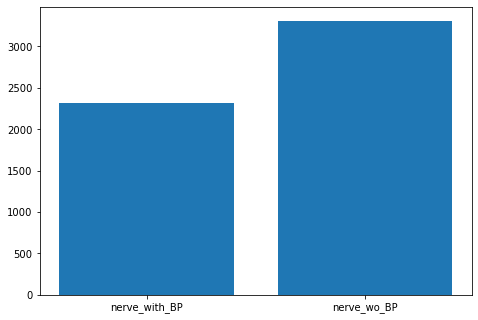

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lables = ['nerve_with_BP', 'nerve_wo_BP']
lables_values = [2323,3312]
ax.bar(lables,lables_values)
plt.show()

In [9]:
print("% of nerve with BP : {:.3f} %".format((nerve_with_BP*100/train_masks.shape[0])))
print("% of nerve without BP : {:.3f} %".format((nerve_wo_BP*100/train_masks.shape[0])))

% of nerve with BP : 41.224 %
% of nerve without BP : 58.776 %


- Here we can observe that Data set is Partially Imbalanced
- Data is in 60:40 Ratio i.e Images with BP nerve are 41.22% and Images without BP nerve are 58.77%

### Reading and Understanding train data

In [10]:
def fimg_to_fmask(img_path):
    # convert an image file path into a corresponding mask file path 
    dirname, basename = os.path.split(img_path)
    maskname = basename.replace(".jpeg", "_mask.jpeg")
    return os.path.join(dirname, maskname)

In [11]:
f_ultrasounds = [img for img in glob("train/*.jpeg") if 'mask' not in img]
# f_ultrasounds.sort()  
f_masks       = [fimg_to_fmask(fimg) for fimg in f_ultrasounds]

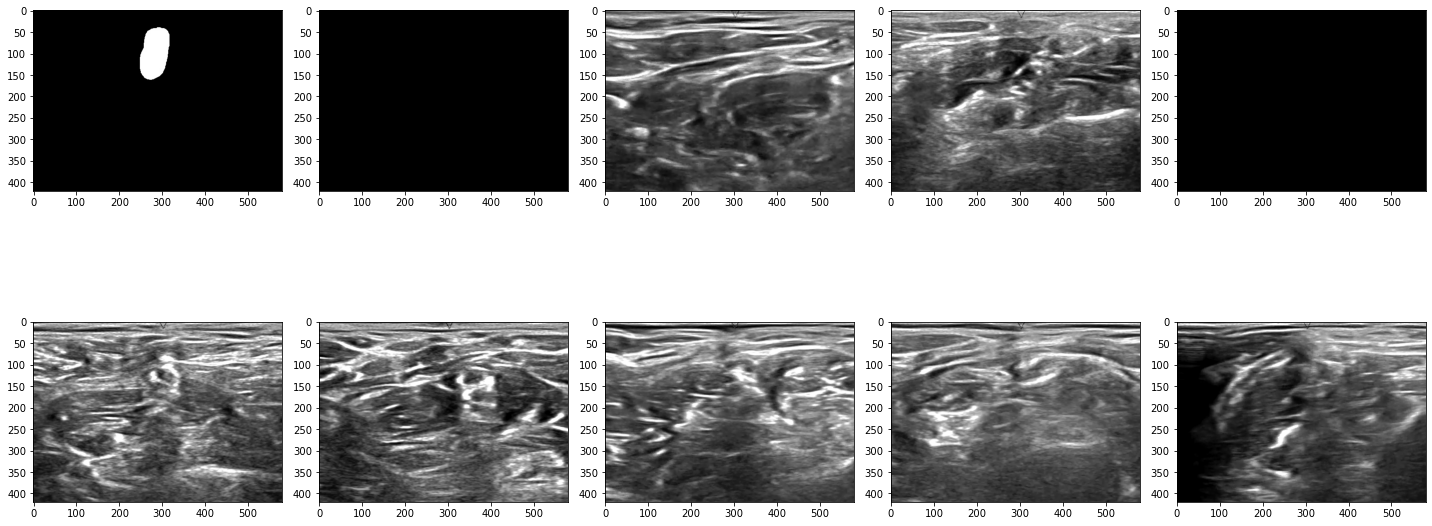

In [12]:

fig = plt.figure(figsize = (20,10))
Plot_loc = 1
for i in np.random.randint(low = 0, high = len(f_ultrasounds), size = 10):
    Image_Path=f_ultrasounds[i]
    img = cv2.imread(Image_Path)
    ax = fig.add_subplot(2, 5, Plot_loc)
    ax.imshow(img, cmap = 'gray')
    Plot_loc+= 1
    

plt.tight_layout()
plt.show()

In [13]:
len(f_ultrasounds)

11270

In [14]:
len(f_masks)

11270

### Cleaning Data

- Checking for the Images that are completely bright or Completely Dark. As, these images do not infer anything.

In [15]:
# Setting the Thresholds for Segregation

DImg_T=(10/255)
BImg_T=(245/255)

DImg=[]
BImg=[]

for idx in tqdm(f_ultrasounds):
    
    #path = os.path.join(Train_Data_Dir, idx)
    
    # Reading The Image
    bgr_img = cv2.imread(idx)
    
    # Splitting into Intensities
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    # Saving as Image Intensity Array
    Imarray = rgb_img / 255

    # Comparing With The Threshold Values
    if(Imarray.max() < DImg_T):
        DImg.append(idx)
        continue 
         
    elif(Imarray.min() > BImg_T):
        BImg.append(idx)
        continue

In [16]:
print("Number of Images That are Too Dark : ",len(DImg))
print("Number of Images That are Too Bright : ",len(BImg))

Number of Images That are Too Dark :  3312
Number of Images That are Too Bright :  0


- There are no Too Dark and Too Bright images in train dataset.

In [17]:
img = cv2.imread(f_ultrasounds[0])
height, width, channels = img.shape
print('Image dimensions: ' + str(height) + 'h x ' + str(width) + 'w - ' + str(channels) + ' channels')

Image dimensions: 420h x 580w - 3 channels


In [18]:
# Setting the Thresholds for Segregation

DImg_T=(10/255)
BImg_T=(245/255)

DImg=[]
BImg=[]

for idx in tqdm(f_masks):
    
    #path = os.path.join(Train_Data_Dir, idx)
    
    # Reading The Image
    bgr_img = cv2.imread(idx)
    
    # Splitting into Intensities
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    # Saving as Image Intensity Array
    Imarray = rgb_img / 255

    # Comparing With The Threshold Values
    if(Imarray.max() < DImg_T):
        DImg.append(idx)
        continue 
         
    elif(Imarray.min() > BImg_T):
        BImg.append(idx)
        continue

ValueError: not enough values to unpack (expected 3, got 0)

In [16]:
print("Number of Images That are Too Dark : ",len(DImg))
print("Number of Images That are Too Bright : ",len(BImg))

Number of Images That are Too Dark :  0
Number of Images That are Too Bright :  0


- There are no Too Dark and Too Bright images in train dataset.

In [17]:
img = cv2.imread(f_ultrasounds[0])
height, width, channels = img.shape
print('Image dimensions: ' + str(height) + 'h x ' + str(width) + 'w - ' + str(channels) + ' channels')

Image dimensions: 420h x 580w - 3 channels
